<a href="https://colab.research.google.com/github/ShreyaMandot/Bigdata/blob/main/BigData_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up PySpark in Colab

In [1]:
!apt-get install openjdk-8-jdk-headless
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

import findspark
findspark.init()
findspark.find()

import pyspark
import numpy as np
import pandas as pd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2022-05-19 16:12:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  39.9MB/s    in 0.3s    

2022-05-19 16:12:32 (39.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


In [4]:
# Utility functions for Spark Cluster Analysis Hands-On
#
#
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')


#Step 1: Attribute Selection
##Import Data
First we read the contents of the file ad-clicks.csv. The following commands read in the CSV file in a table format and removes any extra whitespaces. So, if the CSV contained ' userid ' it becomes 'userid'.

In [5]:
adclicks_df = pd.read_csv('./ad-clicks.csv')
adclicks_df = adclicks_df.rename(columns=lambda x: x.strip())

Next, We are going to add an extra column to the ad-clicks table and make it equal to 1. We do so to record the fact that each ROW is 1 ad-click. We will see how this will become useful when we sum up this column to find how many ads did a user click and display the first 5 lines of adclicks_df and see if a new column has been added:

In [6]:
adclicks_df['adCount'] = 1
adclicks_df.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCount
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies,1
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers,1
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion,1
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing,1


Then let us read the contents of the file game-clicks.csv. The following commands read in the CSV file in a table format and removes any extra whitespaces.

In [7]:
gameclicks_df = pd.read_csv('./game-clicks.csv')
gameclicks_df = gameclicks_df.rename(columns=lambda x: x.strip())

Next, We are going to add an extra column to the game-clicks table and make it equal to 1. We do so to record the fact that each ROW is 1 game-click. we will see how this will become useful when we sum up this column to find how many times did a user click and display it

In [8]:
gameclicks_df['clickCount'] = 1
gameclicks_df.head(5)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel,clickCount
0,2016-05-26 15:06:55,105,1038,5916,0,25,1,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1,1


Next, let us read the contents of the file buy-clicks.csv. As before, the following commands read in the CSV file in a table format and removes any extra whitespaces. So, if the CSV contained ' userid ' it becomes 'userid'.

In [9]:
buyclicks_df = pd.read_csv('./buy-clicks.csv')
buyclicks_df = buyclicks_df.rename(columns=lambda x: x.strip())

#Feature Selection
For this exercise, we can choose from buyclicks_df, the 'price' of each app that a user purchases as an attribute that captures user's purchasing behavior. The following command selects 'userid' and 'price' and drops all other columns that we do not want to use at this stage.

In [10]:
user_purchases = buyclicks_df[['userId','price']] #select only userid and price
user_purchases.head(5)

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


From the adclicks_df, we will use the 'adCount' as an attribute that captures user's inclination to click on ads. The following command selects 'userId' and 'adCount' and drops all other columns that we do not want to use at this stage.

In [11]:
user_adclicks = adclicks_df[['userId','adCount']]

In [ ]:
user_adclicks.head(5)

,userId,adCount
0,611,1
1,1874,1
2,2139,1
3,212,1
4,1027,1


Similarly, from the gameclicks_df, we will use the 'clickCount' as an attribute that captures number of times of user's clicking on game. The following command selects 'userid' and 'clickCount' and drops all other columns that we do not want to use at this stage.

In [12]:
user_gameclicks = gameclicks_df[['userId','clickCount']]
user_gameclicks.head(5)

,userId,clickCount
0,1038,1
1,1099,1
2,899,1
3,2197,1
4,1362,1


##Step 2: Training Data Set Creation
####Create the first aggregate feature for clustering
From each of these single ad-clicks per row, we can now generate total ad clicks per user. Let's pick a user with userid = 3. To find out how many ads this user has clicked overall, we have to find each row that contains userid = 3, and report the total number of such rows.

The following commands sum the total number of ads per user and rename the columns to be called 'userId' and 'totalAdClicks'. In the end, we want to get one row per user, if we are performing clustering over users.

In [13]:
ads_per_user = user_adclicks.groupby('userId').sum()
ads_per_user = ads_per_user.reset_index()
ads_per_user.columns = ['userId', 'totalAdClicks']

ads_per_user.head(5)

,userId,totalAdClicks
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


###Create the second aggregate feature for clustering
The following commands sum the total number of clicking on game per user and rename the columns to be called 'userId' and 'totalGameClicks'. In the end, we want to get one row per user, if we are performing clustering over users.

In [14]:
game_clicks_per_user = user_gameclicks.groupby('userId').sum()
game_clicks_per_user = game_clicks_per_user.reset_index()
game_clicks_per_user.columns = ['userId', 'totalGameClicks'] #rename the columns
game_clicks_per_user.head(5)

,userId,totalGameClicks
0,0,1355
1,1,716
2,2,231
3,6,151
4,8,380


##Create the third aggregate feature for clustering
Similar to what we did for adclicks and gameclicks, here we find out how much money in total did each user spend on buying in-app purchases. As an example, let's pick a user with userId = 9. To find out the total money spent by this user, we have to find each row that contains userId = 9, and report the sum of the column'price' of each product they purchased.

The following commands sum the total money spent by each user and rename the columns to be called 'userId' and 'revenue'.

In [15]:
revenue_per_user = user_purchases.groupby('userId').sum()
revenue_per_user = revenue_per_user.reset_index()
revenue_per_user.columns = ['userId', 'revenue']

##Merge the three tables

In [16]:
combined_df = ads_per_user.merge(game_clicks_per_user, on='userId') #userId, adCount, clickCount
combined_df = combined_df.merge(revenue_per_user, on='userId') 
combined_df.head()


,userId,totalAdClicks,totalGameClicks,revenue
0,1,44,716,21.0
1,8,10,380,53.0
2,9,37,508,80.0
3,10,19,3107,11.0
4,12,46,704,215.0


##Create the final training dataset

In [17]:
cluster_df = combined_df[['totalAdClicks', 'totalGameClicks','revenue']]
cluster_df.head(5)

,totalAdClicks,totalGameClicks,revenue
0,44,716,21.0
1,10,380,53.0
2,37,508,80.0
3,19,3107,11.0
4,46,704,215.0


#Get the dataset dimensions

In [18]:
cluster_df.shape


(543, 3)

In [19]:
cluster_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
totalAdClicks,543.0,29.373849,15.216343,1.0,16.0,30.0,42.0,67.0
totalGameClicks,543.0,707.077348,612.140845,8.0,319.0,555.0,877.5,4599.0
revenue,543.0,39.349908,41.221737,1.0,10.0,25.0,55.0,223.0


All attributes under consideration are numerical or discrete numeric, hence we need to convert them into features using a Vector Assembler. A vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features. Features here are columns. columns, pass it as an input to Vector Assembler, and then use the transform() to convert the input columns into a single vector column called a feature.

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
p_df = spark.createDataFrame(cluster_df)

featuresUsed = ['totalAdClicks', 'totalGameClicks', 'revenue']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(p_df)
assembled.show(5)




+-------------+---------------+-------+------------------+
|totalAdClicks|totalGameClicks|revenue| features_unscaled|
+-------------+---------------+-------+------------------+
|           44|            716|   21.0| [44.0,716.0,21.0]|
|           10|            380|   53.0| [10.0,380.0,53.0]|
|           37|            508|   80.0| [37.0,508.0,80.0]|
|           19|           3107|   11.0|[19.0,3107.0,11.0]|
|           46|            704|  215.0|[46.0,704.0,215.0]|
+-------------+---------------+-------+------------------+
only showing top 5 rows



Now that all columns are transformed into a single feature vector we need to standardize the data to bring them to a comparable scale.

In [21]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features_unscaled',outputCol='features')
scalerModel=scale.fit(assembled)
scaledData=scalerModel.transform(assembled)
scaledData.show(5)

+-------------+---------------+-------+------------------+--------------------+
|totalAdClicks|totalGameClicks|revenue| features_unscaled|            features|
+-------------+---------------+-------+------------------+--------------------+
|           44|            716|   21.0| [44.0,716.0,21.0]|[2.89162773065283...|
|           10|            380|   53.0| [10.0,380.0,53.0]|[0.65718812060291...|
|           37|            508|   80.0| [37.0,508.0,80.0]|[2.43159604623079...|
|           19|           3107|   11.0|[19.0,3107.0,11.0]|[1.24865742914554...|
|           46|            704|  215.0|[46.0,704.0,215.0]|[3.02306535477342...|
+-------------+---------------+-------+------------------+--------------------+
only showing top 5 rows



Now that our data is standardized(featured) we can develop the K Means algorithm. K-means is one of the most commonly used clustering algorithms for grouping data into a predefined number of clusters.

In [22]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='features', k=i)
    KMeans_fit=KMeans_algo.fit(scaledData)
    output=KMeans_fit.transform(scaledData)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score for cluster "+ str(i)+"=", score)

Silhouette Score for cluster 2= 0.46578851335230576
Silhouette Score for cluster 3= 0.5102421145690431
Silhouette Score for cluster 4= 0.5932766393040282
Silhouette Score for cluster 5= 0.4629465318357088
Silhouette Score for cluster 6= 0.5665580239241043
Silhouette Score for cluster 7= 0.4216638802415925
Silhouette Score for cluster 8= 0.4587839834296152
Silhouette Score for cluster 9= 0.47799425600696804


Silhouette Score using ClusteringEvaluator() measures how close each point in one cluster is to points in the neighboring clusters thus helping in figuring out clusters that are compact and well-spaced out.

Text(0, 0.5, 'cost')

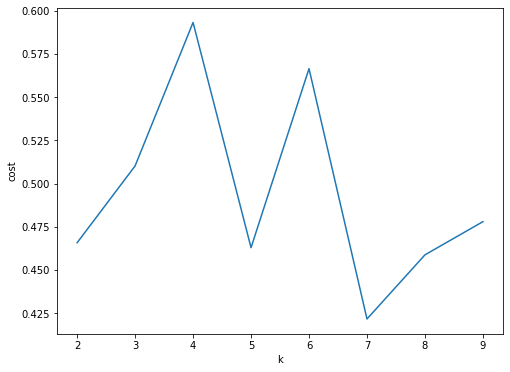

In [23]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Highest value when k = 4

In [24]:
final_clustering=KMeans(featuresCol='features', k=4)
KMeans_fit=final_clustering.fit(scaledData)
clusters_output=KMeans_fit.transform(scaledData)
clusters_output.show(5)

centers = KMeans_fit.clusterCenters()
centers

+-------------+---------------+-------+------------------+--------------------+----------+
|totalAdClicks|totalGameClicks|revenue| features_unscaled|            features|prediction|
+-------------+---------------+-------+------------------+--------------------+----------+
|           44|            716|   21.0| [44.0,716.0,21.0]|[2.89162773065283...|         1|
|           10|            380|   53.0| [10.0,380.0,53.0]|[0.65718812060291...|         0|
|           37|            508|   80.0| [37.0,508.0,80.0]|[2.43159604623079...|         2|
|           19|           3107|   11.0|[19.0,3107.0,11.0]|[1.24865742914554...|         3|
|           46|            704|  215.0|[46.0,704.0,215.0]|[3.02306535477342...|         2|
+-------------+---------------+-------+------------------+--------------------+----------+
only showing top 5 rows



[array([0.9716584 , 0.61865851, 0.54327495]),
 array([2.7434251 , 1.14960371, 0.73891073]),
 array([2.74971319, 1.16358085, 3.03695127]),
 array([1.98470812, 3.61099903, 0.80200405])]